In [ ]:
# here the goal is to evaluate the results from notebook 2 

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

train_pred = pd.read_parquet("../results/baseline/pred_train.parquet")
val_pred   = pd.read_parquet("../results/baseline/pred_val.parquet")

print("Train predictions:", len(train_pred))
print("Val predictions:",   len(val_pred))

train_pred.head()
# loading the deepface prediction files generated in notebook 2 and cheking the number of rows to confirm everything is fine

Train predictions: 7000
Val predictions: 2100


,pred_gender,pred_gender_score,pred_race,pred_race_score,error,file,race_true,gender_true
0,Woman,88.418669,black,43.714210,None,train/60423.jpg,Black,Female
1,Man,97.433734,black,78.286773,None,train/45029.jpg,Black,Female
2,Woman,99.483669,latino hispanic,41.124514,None,train/81730.jpg,Black,Female
3,Man,89.559507,indian,58.377320,None,train/72069.jpg,Black,Female
4,Man,64.608073,black,34.814405,None,train/37655.jpg,Black,Female


In [36]:
train_gt = pd.read_csv("../data/processed/balanced_train.csv")
val_gt   = pd.read_csv("../data/processed/balanced_val.csv")

train = train_pred.merge(train_gt, on="file", how="left")
val   = val_pred.merge(val_gt,   on="file", how="left")

train = train.rename(columns={"gender": "gender_true", "race": "race_true"})
val   = val.rename(columns={"gender": "gender_true", "race": "race_true"})

print(len(train), len(val))
train.head()
# merging predictions with their true labels so I can measure accuracy nd bias

7000 2100


,pred_gender,pred_gender_score,pred_race,pred_race_score,error,file,race_true,gender_true,age,gender_true,race_true,service_test
0,Woman,88.418669,black,43.714210,None,train/60423.jpg,Black,Female,20-29,Female,Black,True
1,Man,97.433734,black,78.286773,None,train/45029.jpg,Black,Female,30-39,Female,Black,False
2,Woman,99.483669,latino hispanic,41.124514,None,train/81730.jpg,Black,Female,20-29,Female,Black,True
3,Man,89.559507,indian,58.377320,None,train/72069.jpg,Black,Female,40-49,Female,Black,False
4,Man,64.608073,black,34.814405,None,train/37655.jpg,Black,Female,40-49,Female,Black,False


In [37]:
gender_map = {
    "Man":   "Male",
    "Woman": "Female",
}

race_map = {
    "black":           "Black",
    "white":           "White",
    "asian":           "East Asian",     
    "indian":          "Indian",
    "latino hispanic": "Latino_Hispanic",
    "middle eastern":  "Middle Eastern",
    "others":          "Other",
}

train["pred_gender"] = train["pred_gender"].replace(gender_map)
val["pred_gender"]   = val["pred_gender"].replace(gender_map)

train["pred_race"] = train["pred_race"].replace(race_map)
val["pred_race"]   = val["pred_race"].replace(race_map)

print("unique predicted genders:", train["pred_gender"].unique())
print("unique predicted races:",   train["pred_race"].unique())
# map deepface label names to the label format used in my dataset so i can compare matching categories instead of mismatched strings

unique predicted genders: ['Female' 'Male']
unique predicted races: ['Black' 'Latino_Hispanic' 'Indian' 'White' 'East Asian' 'Middle Eastern']


In [38]:
print(train.columns)

Index(['pred_gender', 'pred_gender_score', 'pred_race', 'pred_race_score',
       'error', 'file', 'race_true', 'gender_true', 'age', 'gender_true',
       'race_true', 'service_test'],
      dtype='object')


In [39]:
train = train.loc[:, ~train.columns.duplicated()]
val   = val.loc[:, ~val.columns.duplicated()]

print(train.columns)
# remove duplicate columns accidentally created during the merge

Index(['pred_gender', 'pred_gender_score', 'pred_race', 'pred_race_score',
       'error', 'file', 'race_true', 'gender_true', 'age', 'service_test'],
      dtype='object')


In [40]:
train = add_error_cols(train)
val   = add_error_cols(val)

train.head()
# creating binary columns: 1 = correct, 0 = wrong -> these make accuracy calculations easier

,pred_gender,pred_gender_score,pred_race,pred_race_score,error,file,race_true,gender_true,age,service_test,gender_ok,race_ok
0,Female,88.418669,Black,43.714210,None,train/60423.jpg,Black,Female,20-29,True,1,1
1,Male,97.433734,Black,78.286773,None,train/45029.jpg,Black,Female,30-39,False,0,1
2,Female,99.483669,Latino_Hispanic,41.124514,None,train/81730.jpg,Black,Female,20-29,True,1,0
3,Male,89.559507,Indian,58.377320,None,train/72069.jpg,Black,Female,40-49,False,0,0
4,Male,64.608073,Black,34.814405,None,train/37655.jpg,Black,Female,40-49,False,0,1


In [42]:
print("Train accuracy (gender):", train["gender_ok"].mean())
print("Train accuracy (race):",   train["race_ok"].mean())

print("\nVal accuracy (gender):", val["gender_ok"].mean())
print("Val accuracy (race):",     val["race_ok"].mean())
#check to see the global accuracy 

Train accuracy (gender): 0.7582857142857143
Train accuracy (race): 0.4805714285714286

Val accuracy (gender): 0.7476190476190476
Val accuracy (race): 0.46190476190476193


In [43]:
race_acc = train.groupby("race_true")["race_ok"].mean().sort_values(ascending=False)
gender_acc = train.groupby("gender_true")["gender_ok"].mean().sort_values(ascending=False)

print("Race accuracy (train):")
print(race_acc)

print("\nGender accuracy (train):")
print(gender_acc)
# accuracy grouped by race

Race accuracy (train):
race_true
East Asian         0.924
Black              0.754
White              0.734
Indian             0.339
Latino_Hispanic    0.317
Middle Eastern     0.296
Southeast Asian    0.000
Name: race_ok, dtype: float64

Gender accuracy (train):
gender_true
Male      0.943714
Female    0.572857
Name: gender_ok, dtype: float64


In [44]:
train["pred_race"].unique()

array(['Black', 'Latino_Hispanic', 'Indian', 'White', 'East Asian',
       'Middle Eastern'], dtype=object)

In [ ]:
# deepface does not include ‘Southeast Asian’ as a race output, while fairface uses it as a true label
# this causes deepface to systematically misclassify all Southeast Asian samples ->  0 in accuracy for this group

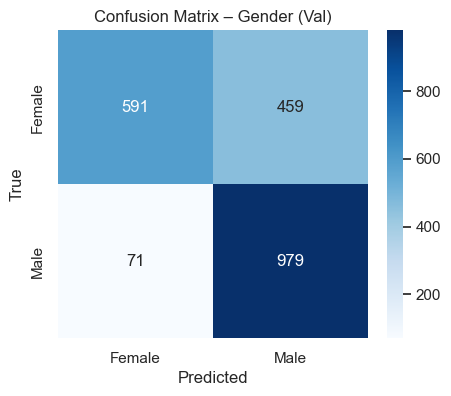

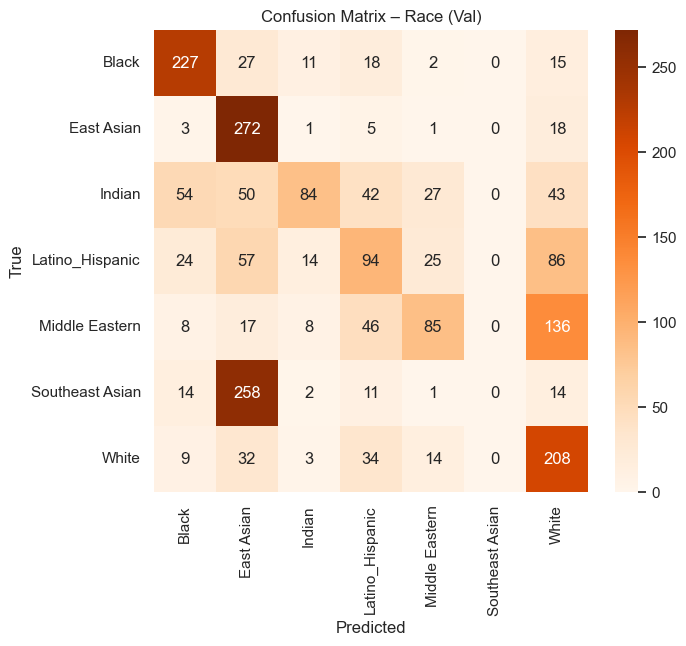

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_gender = confusion_matrix(val["gender_true"], val["pred_gender"])
plt.figure(figsize=(5,4))
sns.heatmap(cm_gender, annot=True, fmt="d", cmap="Blues",
            xticklabels=val["gender_true"].unique(),
            yticklabels=val["gender_true"].unique())
plt.title("Confusion Matrix – Gender (Val)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

cm_race = confusion_matrix(val["race_true"], val["pred_race"])
plt.figure(figsize=(7,6))
sns.heatmap(cm_race, annot=True, fmt="d", cmap="Oranges",
            xticklabels=sorted(val["race_true"].unique()),
            yticklabels=sorted(val["race_true"].unique()))
plt.title("Confusion Matrix – Race (Val)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# confusion matrix - gender
# it shows a strong biais: deepface predicts men far more easily than women
# male faces are correctly classified most of the time but almost 1/2 of female faces are misclassified 

In [ ]:
# confusion matrix - race
# deepface shows strong racial bias across groups
# it performs well for east asian, white and black faces
# it performs poorly for indian, middle eastern and latino faces
# southeast asian has 0 percent accuracy because deepface does not include this group
# this makes the model systematically misclassify southeast asian as east asian

/var/folders/31/rkbg1v9556n0c1j018sygfc00000gn/T/ipykernel_34912/2259934648.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=race_acc_val.index, y=race_acc_val.values, palette="viridis")


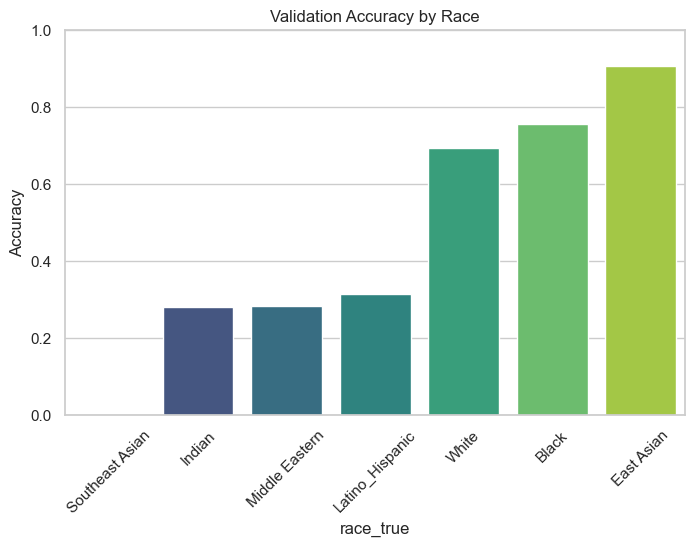

/var/folders/31/rkbg1v9556n0c1j018sygfc00000gn/T/ipykernel_34912/2259934648.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_acc_val.index, y=gender_acc_val.values, palette="viridis")


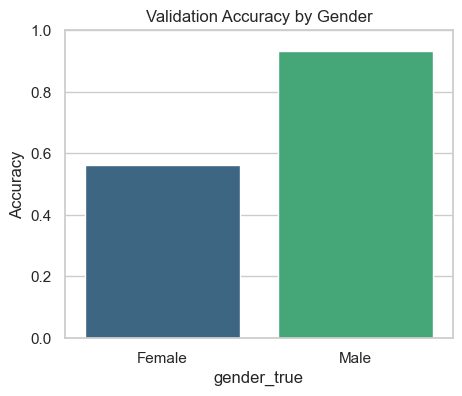

In [46]:
# Accuracy by race (Val)
race_acc_val = val.groupby("race_true")["race_ok"].mean().sort_values()

plt.figure(figsize=(8,5))
sns.barplot(x=race_acc_val.index, y=race_acc_val.values, palette="viridis")
plt.title("Validation Accuracy by Race")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()

# Accuracy by gender (Val)
gender_acc_val = val.groupby("gender_true")["gender_ok"].mean().sort_values()

plt.figure(figsize=(5,4))
sns.barplot(x=gender_acc_val.index, y=gender_acc_val.values, palette="viridis")
plt.title("Validation Accuracy by Gender")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

In [ ]:
# validation accuracy by race:
# deepface performs best on east asian faces (~0.90), followed by black (~0.75) and white (~0.70)
# all brown-skinned groups (indian, middle eastern, latino) fall below 0.35
# southeast asian has 0 accuracy because the class does not exist in deepface

In [ ]:
# validation accuracy by gender:
# gender accuracy is highly imbalanced: 
# the model predicts mens correctly almost 90% of the time, while accuracy for womens is only around 58%
# deepface systematically overpredicts ‘Male’

/var/folders/31/rkbg1v9556n0c1j018sygfc00000gn/T/ipykernel_34912/2671674295.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_rate_race.index, y=error_rate_race.values, palette="magma")


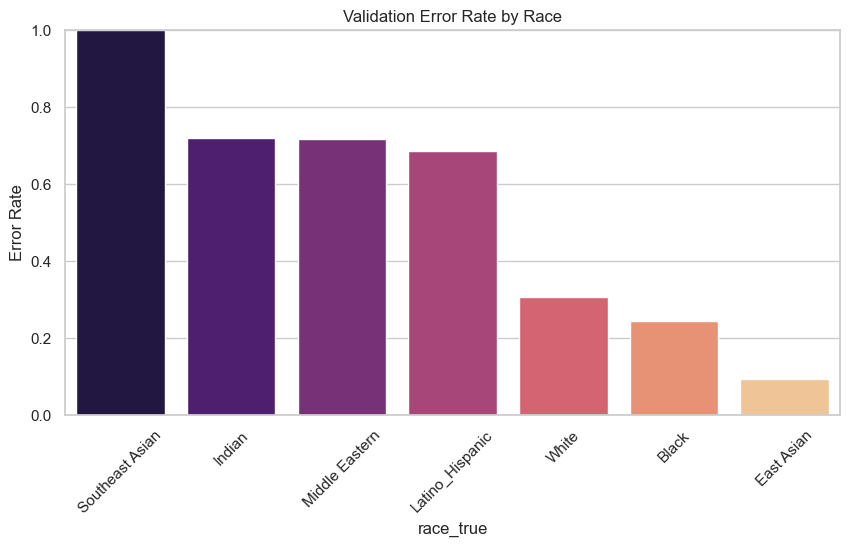

In [47]:
error_rate_race = 1 - race_acc_val

plt.figure(figsize=(10,5))
sns.barplot(x=error_rate_race.index, y=error_rate_race.values, palette="magma")
plt.title("Validation Error Rate by Race")
plt.ylabel("Error Rate")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# validation error rate by race:
# error rates mirror the accuracy plot: east asian and black and white  have the lowest errors, while brown-skinned groups show very high one
# southeast asian reaches a 100 percent error rate because the class does not exist in deepface and is always misclassified

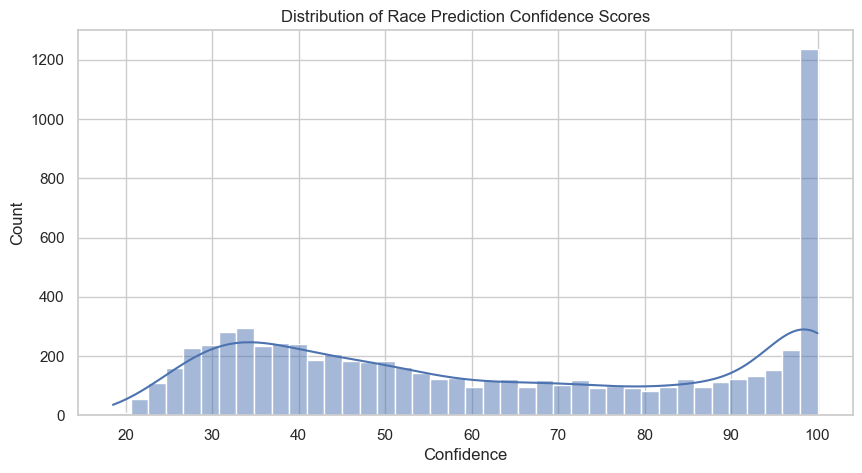

In [48]:
plt.figure(figsize=(10,5))
sns.histplot(train["pred_race_score"], kde=True, bins=40)
plt.title("Distribution of Race Prediction Confidence Scores")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.show()

In [ ]:
# distribution of race prediction confidence:
# the model shows a bimodal pattern with many low confidence guesses between 20 and 40 % and a huge spike at 100 %
# deepface is often extremely overconfident even when it is wrong especially on minority groups